In [1]:
import sys

sys.path.append("../")

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from main import X_and_P_ops, RY_ansatz, VarFourier, tomatrix

np.random.seed(0)  # For reproducibility

In this notebook we show how to use our framework to obtain the ground state of the harmonic oscilator with Variational Fourier Analysis. 

We first define the number of qubits and the device for the simulation.

In [3]:
num_qubits = 6
device = qml.device("default.qubit", wires=num_qubits)

We then assemble the Hamiltonian of the harmonic oscilator,

$$H=\frac{1}{2}( P^2 + X^2 )$$

using `X_and_P_ops` which handles the space discretization and creates the 
`X` and `P` operators holding the information required for latter steps.

In [69]:
X, P = X_and_P_ops(range(num_qubits), x_min=-5, x_max=5, semiclassical=True)

Hamil = [X.pow(2).s_prod(0.5), P.pow(2).s_prod(0.5)]

For posterior checking, we obtain its ground state by matricial calculations.

In [70]:
Hamil_matrix = tomatrix(Hamil)

vals, vecs = np.linalg.eigh(Hamil_matrix)
val = vals[0]
vec = vecs[:, 0]
val

0.4999999999633249

Defining the initial state of the circuits and the variational circuit,

In [71]:
def init_state():
    pass

In [7]:
num_layers_max = num_qubits
params_ground_vec = []
energies_ground_vec = []

for num_layers in range(1,num_layers_max+2):
    print(f"_____ Current layer = {num_layers}")
    var_state_class = RY_ansatz(num_qubits, num_layers)
    var_state = var_state_class.construct_circuit
    num_params = var_state_class.num_params
    varqft = VarFourier(Hamil, device, var_state=var_state, init_state=init_state)
    params_init = np.random.randn(num_params) * 0.01

    params_ground, energies_ground = varqft.run(
        params_init,
        max_iterations=1000,
        learning_rate=0.1,
        conv_tol = 1e-6
    )

    params_ground_vec.append(params_ground)
    energies_ground_vec.append(energies_ground)
#qml.draw_mpl(var_state, style="pennylane")(num_params * [0])

_____ Current layer = 1
Step:    200, Energy:     3.838411
_____ Current layer = 2
Step:    224, Energy:     1.814588
_____ Current layer = 3
Step:    443, Energy:     0.944790
_____ Current layer = 4
Step:   1000, Energy:     0.590808
_____ Current layer = 5
Step:   1000, Energy:     0.510698
_____ Current layer = 6
Step:   1000, Energy:     0.504833
_____ Current layer = 7
Step:   1000, Energy:     0.506041


In [74]:
num_layers_max = num_qubits
params_ground_SC_vec = []
energies_ground_SC_vec = []

for num_layers in range(1,num_layers_max+2):
    print(f"_____ Current layer = {num_layers}")
    var_state_class = RY_ansatz(num_qubits, num_layers)
    var_state = var_state_class.construct_circuit
    num_params = var_state_class.num_params
    varqft = VarFourier(Hamil, device, var_state=var_state, init_state=init_state)
    params_init = np.random.randn(num_params) * 0.01

    params_ground, energies_ground = varqft.run(
        params_init,
        max_iterations=1000,
        learning_rate=0.1,
        conv_tol = 1e-6
    )

    params_ground_SC_vec.append(params_ground)
    energies_ground_SC_vec.append(energies_ground)
#qml.draw_mpl(var_state, style="pennylane")(num_params * [0])

_____ Current layer = 1
Step:    199, Energy:     3.838408
_____ Current layer = 2
Step:    285, Energy:     1.814592
_____ Current layer = 3
Step:    251, Energy:     0.944787
_____ Current layer = 4
Step:    481, Energy:     0.585146
_____ Current layer = 5
Step:   1000, Energy:     0.505248
_____ Current layer = 6
Step:   1000, Energy:     0.505775
_____ Current layer = 7
Step:    465, Energy:     0.501786


In [63]:
optim_energies_vec = []
optim_states_vec = []
fidelities_vec = []
for num_layers in range(0,num_layers_max+1):

    var_state_class = RY_ansatz(num_qubits, num_layers+1)
    var_state = var_state_class.construct_circuit
    num_params = var_state_class.num_params
    varqft = VarFourier(Hamil, device, var_state=var_state, init_state=init_state)
    
    optim_energies_vec.append(np.min(energies_ground_vec[num_layers]))
    optim_params = params_ground_vec[num_layers][energies_ground_vec[num_layers].index(optim_energies_vec[-1])]
    optim_states_vec.append(varqft.state( optim_params ))
    fidelities_vec.append( np.abs( np.vdot( optim_states_vec[-1] , vec) ) ** 2)

In [77]:
optim_energies_SC_vec = []
optim_states_SC_vec = []
fidelities_SC_vec = []
for num_layers in range(0,num_layers_max+1):

    var_state_class = RY_ansatz(num_qubits, num_layers+1)
    var_state = var_state_class.construct_circuit
    num_params = var_state_class.num_params
    varqft = VarFourier(Hamil, device, var_state=var_state, init_state=init_state)
    
    optim_energies_SC_vec.append(np.min(energies_ground_SC_vec[num_layers]))
    optim_params = params_ground_SC_vec[num_layers][energies_ground_SC_vec[num_layers].index(optim_energies_SC_vec[-1])]
    optim_states_SC_vec.append(varqft.state( optim_params ))
    fidelities_SC_vec.append( np.abs( np.vdot( optim_states_SC_vec[-1] , vec) ) ** 2)

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 120
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [4]:
optim_energies_vec = [3.8384109744499533, 1.8145879766108135, 0.9447890363131418, 0.5902683496051573, 0.5080829071158655, 0.5027335962864705, 0.500894604971506]
fidelities_vec = [0.3698656387165926, 0.875528183131378, 0.9738518886545564, 0.9858220630651171, 0.9995933000109846, 0.9995892956178419, 0.9999599423116505]
optim_energies_SC_vec = [3.838407420891319, 1.814591595290628, 0.9447865565794347, 0.5851457452130793, 0.5050733708264824, 0.5030171686507046, 0.5017862686186889]
fidelities_SC_vec = [0.3700380856190093, 0.8755840823208622, 0.9736673554696159, 0.9890142911299019, 0.9995832344840315, 0.9994788468836684, 0.9998486217913376]

In [5]:
print(optim_energies_vec)

print(fidelities_vec)

print(optim_energies_SC_vec)

print(fidelities_SC_vec)

[3.8384109744499533, 1.8145879766108135, 0.9447890363131418, 0.5902683496051573, 0.5080829071158655, 0.5027335962864705, 0.500894604971506]
[0.3698656387165926, 0.875528183131378, 0.9738518886545564, 0.9858220630651171, 0.9995933000109846, 0.9995892956178419, 0.9999599423116505]
[3.838407420891319, 1.814591595290628, 0.9447865565794347, 0.5851457452130793, 0.5050733708264824, 0.5030171686507046, 0.5017862686186889]
[0.3700380856190093, 0.8755840823208622, 0.9736673554696159, 0.9890142911299019, 0.9995832344840315, 0.9994788468836684, 0.9998486217913376]


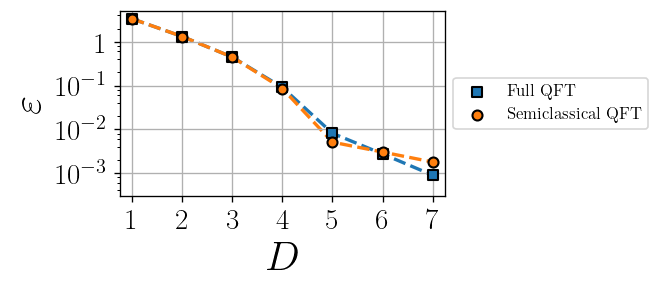

In [91]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(3.5,2)
Dmax = len(optim_energies_vec)
colors = plt.cm.viridis(np.linspace(0,1,Dmax))
#colors = sns.color_palette("tab10",as_cmap=True)(np.linspace(0,1,M))
total_layers = np.arange(1,int(Dmax)+1)

ax.scatter(total_layers , optim_energies_vec - 0.5*np.ones( Dmax ) , label = 'Full QFT' , linewidth=1.25,marker='s',edgecolor='black',zorder=12)
ax.plot(total_layers , optim_energies_vec - 0.5*np.ones( Dmax ) ,  linestyle = 'dashed' , linewidth=2,zorder=1)

ax.scatter(total_layers , optim_energies_SC_vec - 0.5*np.ones( Dmax ) , label = 'Semiclassical QFT', linewidth=1.25,marker='o',edgecolor='black',zorder=12)
ax.plot(total_layers , optim_energies_SC_vec - 0.5*np.ones( Dmax ) ,  linestyle = 'dashed' , linewidth=2,zorder=1)

ax.set_yscale('log')

ax.set_xlabel(r'$D$',fontsize=25)
ax.set_ylabel(r"$\varepsilon$",fontsize=25)
ax.tick_params(axis='both', labelsize=17.5)
#restore_minor_ticks_log_plot(ax)
from matplotlib import ticker as mticker
ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs=(.2, .4, .6, .8)))
ax.set_yticks([10,1,1e-1,1e-2,1e-3])
ax.set_yticklabels([r'$10^{1}$',r'$1$',r'$10^{-1}$',r'$10^{-2}$',r'$10^{-3}$'])
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels([r'$1$',r'$2$',r'$3$',r'$4$',r'$5$',r'$6$',r'$7$'])#,r'$7$',r'$9$'])
ax.set_xlim([0.75,Dmax+0.25])
ax.set_ylim([3*1e-4,5])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1., box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

plt.savefig("../figures/residual_energy_oscillator.pdf",bbox_inches='tight',dpi=600)


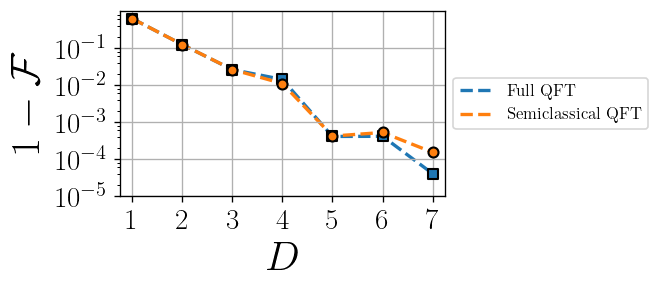

In [109]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(3.5,2)
Dmax = len(optim_energies_vec)
colors = plt.cm.viridis(np.linspace(0,1,Dmax))
#colors = sns.color_palette("tab10",as_cmap=True)(np.linspace(0,1,M))
total_layers = np.arange(1,int(Dmax)+1)

ax.scatter(total_layers , np.ones( Dmax ) - fidelities_vec  , linewidth=1.25, marker='s',edgecolor='black',zorder=12)
ax.plot(total_layers , np.ones( Dmax ) - fidelities_vec , label = 'Full QFT',  linestyle = 'dashed' , linewidth=2,zorder=1)

ax.scatter(total_layers , np.ones( Dmax ) - fidelities_SC_vec  , linewidth=1.25,marker='o',edgecolor='black',zorder=12)
ax.plot(total_layers , np.ones( Dmax ) - fidelities_SC_vec ,  label = 'Semiclassical QFT', linestyle = 'dashed' , linewidth=2,zorder=1)
ax.set_yscale('log')

ax.set_xlabel(r'$D$',fontsize=25)
ax.set_ylabel(r"$1-\mathcal{F}$",fontsize=25)
ax.tick_params(axis='both', labelsize=17.5)
#restore_minor_ticks_log_plot(ax)
from matplotlib import ticker as mticker
ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs=(.2, .4, .6, .8)))
ax.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5])
#ax.set_yticklabels([r'$10^{-1}$',r'$10^{-2}$',r'$10^{-3}$',r'$10^{-4}$',r'$10^{-5}'])
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels([r'$1$',r'$2$',r'$3$',r'$4$',r'$5$',r'$6$',r'$7$'])#,r'$7$',r'$9$'])
ax.set_xlim([0.75,Dmax+0.25])
ax.set_ylim([1e-5,1])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1., box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

plt.savefig("../figures/rfidelity_oscillator.pdf",bbox_inches='tight',dpi=600)


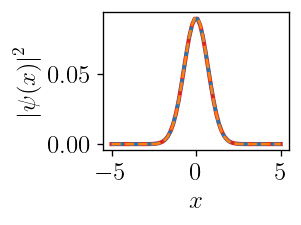

In [106]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(2,1.5)
ax.plot(np.linspace(-5,5,2**(num_qubits)), np.abs(optim_states_vec[-1])**2, '--', linewidth=2)
ax.plot(np.linspace(-5,5,2**(num_qubits)), np.abs(optim_states_SC_vec[-1])**2, '--')
ax.plot( np.linspace(-5,5,2**(num_qubits)), np.abs(vec)**2, color='tab:red', linewidth=2.5, zorder=0) 

ax.set_xlabel(r'Steps',fontsize=15)
ax.set_xlabel(r'$x$',fontsize=15)
ax.set_ylabel(r"$\langle H \rangle_{\theta}$",fontsize=15)
ax.set_ylabel(r"$\left|\psi(x)\right|^2$",fontsize=15)

ax.tick_params(axis='both', labelsize=15)
ax.tick_params(axis='both', labelsize=15)

plt.savefig("../figures/wfs_oscillator.pdf",bbox_inches='tight',dpi=600)
